In [ ]:
# Import necessary libraries
from db_utils import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import shutil

In [ ]:
if os.path.isdir('results'):
    try:
        # Recursively deletes the directory and everything inside it
        shutil.rmtree('results')
        print(f"Directory 'results' successfully deleted.")
    except FileNotFoundError:
        print(f"Error: Directory 'results' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

os.makedirs('results')
print("Directory 'results' has been created.")

Directory 'results' successfully deleted.
Directory 'results' has been created.


In [ ]:
def initialize_db():
    '''
    Initializes the database by creating the necessary tables and inserting data from a Feather file.
    '''
    
    # Call the function to create the database file and establish connection (if it doesn't exist)
    print('-'*100)
    create_db()

    # Call the function responsible for creating the 'sales' (or other necessary) table structure
    print('-'*100)
    create_table()

    # Call the function to read the specified Feather file and load its data into the created database table
    print('-'*100)
    insert_data('data/first_question_data.feather')

initialize_db()

----------------------------------------------------------------------------------------------------
Database named 'sales.db' created successfully.
----------------------------------------------------------------------------------------------------
Table created successfully.
----------------------------------------------------------------------------------------------------
Data inserted successfully from Feather file.


----------------------------------------------------------------------------------------------------
First Question Part A Results:

  sales_date_id  total_sales  total_sales_count  customer_count
0    2022-10-01    624269.63                175             162
1    2022-10-02    559289.20                162             151
2    2022-10-03    549015.19                156             144
3    2022-10-04    550293.91                157             132
4    2022-10-05    508049.41                147             139

Plot saved as 'q1a_analysis_new_colors.png'.


[(20221001, 624269.6294023816, 175, 162),
 (20221002, 559289.2033659472, 162, 151),
 (20221003, 549015.1936014199, 156, 144),
 (20221004, 550293.9148863435, 157, 132),
 (20221005, 508049.4110606514, 147, 139),
 (20221006, 565242.5099225419, 163, 150),
 (20221007, 593874.2290242492, 162, 153),
 (20221008, 560936.9703689424, 156, 142),
 (20221009, 535770.6175339167, 159, 147),
 (20221010, 612574.7478483085, 170, 147),
 (20221011, 581390.7237491392, 163, 151),
 (20221012, 649935.4573178372, 178, 160),
 (20221013, 529345.5013812083, 158, 144),
 (20221014, 616228.3726780845, 166, 146),
 (20221015, 545432.6211809381, 157, 145),
 (20221016, 607602.7158271157, 172, 160),
 (20221017, 603549.0858809976, 172, 160),
 (20221018, 566304.6390995601, 151, 143),
 (20221019, 612470.4349447178, 183, 170),
 (20221020, 588198.3295499859, 168, 157),
 (20221021, 598324.7778889994, 166, 154),
 (20221022, 584006.3071157328, 173, 157),
 (20221023, 574188.45165861, 163, 146),
 (20221024, 535671.9503890843, 143, 

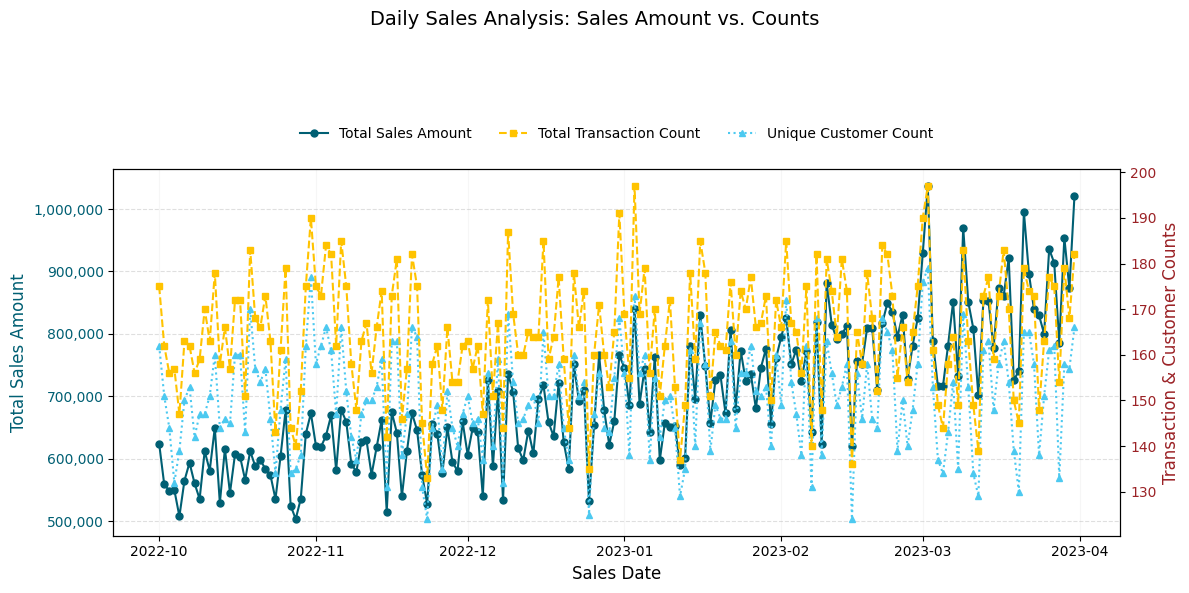

In [ ]:
def q1a_analysis():
    '''
    Returns the combined results of daily total sales, total sales count, and total customer count by sales_date_id.
    
    The function first ensures the necessary SQL views are created by calling helper functions,
    then joins the data from these views and visualizes the trends.
    
    Returns:
        list: List of tuples containing sales_date_id, total sales, total sales count, and customer count.
    '''

    # Prepare daily aggregation views
    # Execute helper functions to create the necessary SQL views (total sales, transaction count, unique customer count)
    # The views are created as a side-effect for the main query to join later
    _ = daily_sale_amount()
    _ = daily_sale_count_by_sales_date()
    _ = daily_customer_sale_count_by_sales_date()

    # Connect to database
    conn, cur = connect_db()

    # Join the data from the three previously created views (s1, s2, s3)
    cur.execute('''
        SELECT
            s1.sales_date_id,
            s1.total_sale_amount,
            s2.sale_counter,
            s3.customer_counter
        FROM
            sale_amount AS s1
        INNER JOIN
            daily_sale_count AS s2 ON s1.sales_date_id = s2.sales_date_id
        INNER JOIN
            customer_count AS s3 ON s1.sales_date_id = s3.sales_date_id
        ORDER BY
            s1.sales_date_id ASC -- Changed to ASC for chronological plotting
                ''')

    results = cur.fetchall()

    # Commit the changes and close the connection
    commit_and_close(conn)

    # Load the SQL results into a Pandas DataFrame for easy manipulation and plotting
    df = pd.DataFrame(results, columns=[
        'sales_date_id', 'total_sales', 'total_sales_count', 'customer_count'])

    # Convert the sales_date_id (e.g., integer 20240928) to a proper datetime object for correct time-series plotting on the X-axis
    df['sales_date_id'] = pd.to_datetime(df['sales_date_id'], format='%Y%m%d')

    # Set display option to format floats with 2 decimal places for cleaner output
    pd.set_option("display.float_format", "{:.2f}".format)

    print('-'*100)
    print("First Question Part A Results:\n")
    # Display the first few rows of the processed DataFrame
    print(df.head())

    # VISUALIZATION - Combined line graphs

    # Initialize the figure and primary Y-axis (left)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Set the overall title
    fig.suptitle('Daily Sales Analysis: Sales Amount vs. Counts', fontsize=14)

    # Define new color palette
    color_sales_axis = '#005F73'   # Dark Teal/Navy for Sales
    color_counts_axis = '#9B2226'  # Dark Red for the Counts Axis Label
    color_trans_count = '#FFC300'  # Bright Yellow/Orange for Transactions
    color_cust_count = '#4CC9F0'   # Light Sky Blue for Customers
    
    # Primary Y-axis (left): Total Sales Amount
    ax1.set_xlabel('Sales Date', fontsize=12)
    ax1.set_ylabel('Total Sales Amount', color=color_sales_axis, fontsize=12)
    
    # Plot total sales amount (primary metric - solid line)
    line1, = ax1.plot(df['sales_date_id'], df['total_sales'], 
                      marker='o', markersize=5, linestyle='-', 
                      color=color_sales_axis, label='Total Sales Amount', zorder=3)
    
    ax1.tick_params(axis='y', labelcolor=color_sales_axis)

    # Format primary axis for commas
    ax1.get_yaxis().set_major_formatter(
         ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Grid: Light vertical lines (X-axis) and light dashed horizontal lines (Primary Y-axis)
    ax1.grid(True, linestyle='-', alpha=0.1, axis='x') 
    ax1.grid(True, linestyle='--', alpha=0.4, axis='y') 
    

    # Sezondary axis (right): Transaction and Customer Counts
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Transaction & Customer Counts', color=color_counts_axis, fontsize=12)

    # Plot Transaction Count: Dashed line, distinct color
    line2, = ax2.plot(df['sales_date_id'], df['total_sales_count'], 
                      marker='s', markersize=4, linestyle='--', linewidth=1.5,
                      color=color_trans_count, label='Total Transaction Count', zorder=2)

    # Plot Customer Count: Dotted line, distinct color for separation from trans count
    line3, = ax2.plot(df['sales_date_id'], df['customer_count'], 
                      marker='^', markersize=4, linestyle=':', linewidth=1.5,
                      color=color_cust_count, label='Unique Customer Count', zorder=1)
    
    ax2.tick_params(axis='y', labelcolor=color_counts_axis)
    
    # Disable the grid on the secondary axis to avoid overwhelming the chart
    ax2.grid(False) 

    # Combine and position the legend above the plot
    lines = [line1, line2, line3]
    ax1.legend(lines, [l.get_label() for l in lines], 
               loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)
    
    # Rotate X-axis date labels for readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to fit elements (title, legend, labels) neatly
    fig.tight_layout(rect=[0, 0, 1, 0.9]) 

    # Save the generated figure to a high-resolution PNG file
    plt.savefig('results/q1a_analysis_new_colors.png', dpi=300)
    print("\nPlot saved as 'q1a_analysis_new_colors.png'.")

    return results

q1a_analysis()

----------------------------------------------------------------------------------------------------
First Question Part B Results:

Monthly Total Sales Amount Data Sample:
  sales_month  customer_id  monthly_total_amount
0     2023-03            1              21640.65
1     2023-03            2              23669.17
2     2023-03            3              60196.54
3     2023-03            4              16768.98
4     2023-03            5              22914.84

Monthly Sales Count Data Sample:
  sales_month  customer_id  monthly_sales_count
0     2023-03            1                    4
1     2023-03            2                    4
2     2023-03            3                   11
3     2023-03            4                    3
4     2023-03            5                    5

Combined (Long) Data Sample:
  sales_month  customer_id              Metric    Value
0     2023-03            1  Total Sales Amount 21640.65
1     2023-03            2  Total Sales Amount 23669.17
2     2023-03

(     sales_month  customer_id  monthly_total_amount
 0        2023-03            1              21640.65
 1        2023-03            2              23669.17
 2        2023-03            3              60196.54
 3        2023-03            4              16768.98
 4        2023-03            5              22914.84
 ...          ...          ...                   ...
 5352     2022-10          892              48264.04
 5353     2022-10          893              29972.93
 5354     2022-10          894              14355.82
 5355     2022-10          895               9095.67
 5356     2022-10          896              19063.86
 
 [5357 rows x 3 columns],
      sales_month  customer_id  monthly_sales_count
 0        2023-03            1                    4
 1        2023-03            2                    4
 2        2023-03            3                   11
 3        2023-03            4                    3
 4        2023-03            5                    5
 ...          ...       

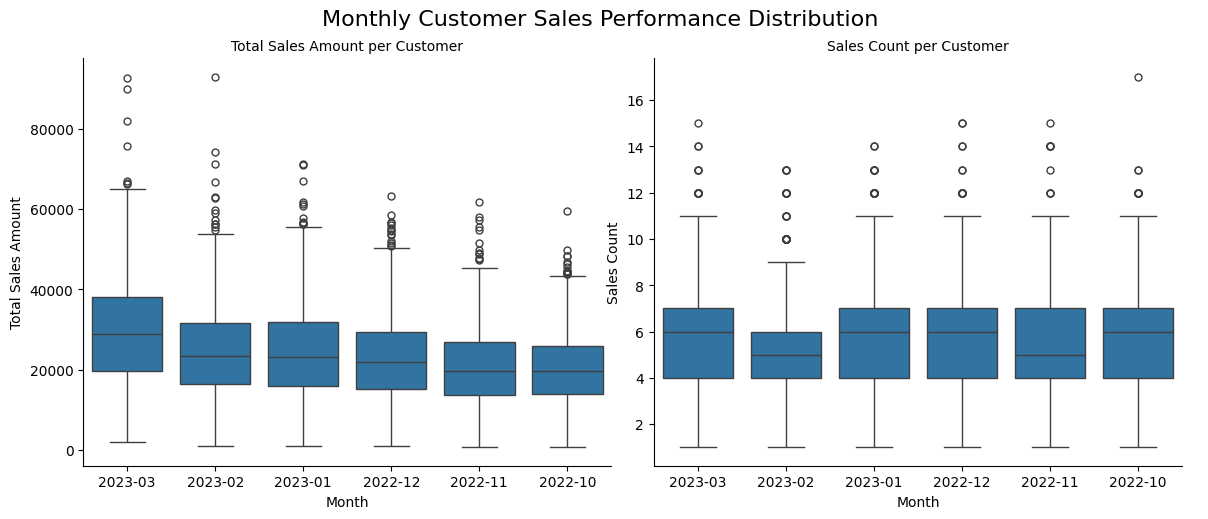

In [ ]:
def q1b_analysis():
    '''
    Returns the combined results of monthly sales count and total sales amount per customer.
    
    The function calls helper functions to retrieve monthly aggregates, converts the results 
    into DataFrames, and visualizes the distribution of the two key metrics (amount and count) 
    using box plots.

    Returns:
        tuple: A tuple containing two pandas DataFrames:
               - df_total_amount: Monthly total sales amount per customer.
               - df_count: Monthly total sales count per customer.
    '''

    # Call helper function to fetch aggregated monthly total sales amount per customer from the DB
    df_total_amount = pd.DataFrame(monthly_sales_amount_per_customer(), columns=[
        'sales_month', 'customer_id', 'monthly_total_amount'])
    
    # Call helper function to fetch aggregated monthly sales count (transactions) per customer from the DB
    df_count = pd.DataFrame(monthly_sales_counter_per_customer(), columns=[
        'sales_month', 'customer_id', 'monthly_sales_count'])

    print('-'*100)
    print("First Question Part B Results:\n")
    print("Monthly Total Sales Amount Data Sample:")

    # Convert the sales_month column (YYYYMM integer/string) to a period index ('M' for Month) for better categorical plotting and readability on the X-axis
    df_total_amount['sales_month'] = pd.to_datetime(
        df_total_amount['sales_month'], format='%Y%m').dt.to_period('M')
    print(df_total_amount.head())

    print("\nMonthly Sales Count Data Sample:")
    # Apply the same month conversion to the sales count DataFrame
    df_count['sales_month'] = pd.to_datetime(
        df_count['sales_month'], format='%Y%m').dt.to_period('M')
    print(df_count.head())

    # Merge the two DataFrames on 'sales_month' and 'customer_id' to create a single row for each customer's performance in a given month
    df_combined = pd.merge(df_total_amount, df_count, 
                           on=['sales_month', 'customer_id'], 
                           how='inner')

    # Convert the 'sales_month' period object back to string for plotting
    df_combined['sales_month'] = df_combined['sales_month'].astype(str)
    
    # Convert the data to 'long' format for seaborn.catplot to plot both metrics simultaneously
    df_long = df_combined.melt(
        id_vars=['sales_month', 'customer_id'],
        value_vars=['monthly_total_amount', 'monthly_sales_count'],
        var_name='Metric',  # New column to hold the metric type
        value_name='Value'  # New column to hold the metric value
    )
    
    # Rename metric values for better plot readability
    df_long['Metric'] = df_long['Metric'].replace({
        'monthly_total_amount': 'Total Sales Amount',
        'monthly_sales_count': 'Sales Count'
    })
    
    print("\nCombined (Long) Data Sample:")
    print(df_long.head())

    # VISUALIZATION: Comparative Box Plots
    
    # Create separate columns for each metric (Sales Amount and Sales Count)
    g = sns.catplot(
        data=df_long,
        x='sales_month',
        y='Value',
        col='Metric',         # Separate plots by metric type (creates 2 columns)
        kind='box',           
        sharey=False,         # Ensure each box plot has its own Y-axis scale
        height=5, 
        aspect=1.2,
    )
    
    # Customize the plot appearance
    g.fig.suptitle('Monthly Customer Sales Performance Distribution', fontsize=16, y=1.03)
    g.set_axis_labels("Month", "")
    g.set_titles(col_template="{col_name} per Customer") # Set subplot titles
    
    # Manually set the specific Y-axis labels
    g.axes.flat[0].set_ylabel("Total Sales Amount")
    g.axes.flat[1].set_ylabel("Sales Count")

    # Sort the X-axis labels (months) in reverse order (most recent month first)
    months = df_long['sales_month'].unique()
    months.sort()
    months = months[::-1] 
    g.set_xticklabels(months)
    
    
    # Save the generated figure
    g.fig.savefig('results/q1b_analysis_combined_catplot.png', dpi=300)
    print("\nPlot saved as 'q1b_analysis_combined_catplot.png'.")

    return df_total_amount, df_count

q1b_analysis()

In [ ]:
def evaluate_metrics(df, threshold=0.5):
    '''
    Evaluates classification performance metrics (Accuracy, Precision, Recall, F1-Score) 
    based on a DataFrame containing actual labels and predicted probabilities.

    Args:
        df (pd.DataFrame): DataFrame with 'actual_label' (0 or 1) and 'probability' (0.0 to 1.0) columns.
        threshold (float): The probability threshold used to convert probabilities into binary predictions.

    Returns:
        tuple: (tp, fp, tn, fn, threshold, accuracy, precision, recall, f1_score)
    '''

    # Set the threshold (default is 0.5)
    # Converts the continuous 'probability' into a binary 'predicted_label' (1 if probability >= threshold, else 0).
    df['predicted_label'] = np.where(df['probability'] >= threshold, 1, 0)

    # True Positives (TP): Actual 1 and Predicted 1 (Correctly predicted positive)
    tp = ((df['actual_label'] == 1) &
          (df['predicted_label'] == 1)).sum()
          
    # False Positives (FP): Actual 0 and Predicted 1 (Type I error: Predicted positive wrongly)
    fp = ((df['actual_label'] == 0) &
          (df['predicted_label'] == 1)).sum()
          
    # True Negatives (TN): Actual 0 and Predicted 0 (Correctly predicted negative)
    tn = ((df['actual_label'] == 0) &
          (df['predicted_label'] == 0)).sum()
          
    # False Negatives (FN): Actual 1 and Predicted 0 (Type II error: Predicted negative wrongly)
    fn = ((df['actual_label'] == 1) &
          (df['predicted_label'] == 0)).sum()

    # Precision: (TP / (TP + FP)) - How many predicted positives were actually positive
    # Checks for division by zero to prevent error if no positive predictions were made
    precision = 0.0 if tp + \
        fp == 0 else tp / (tp+fp)
        
    # Recall (Sensitivity): (TP / (TP + FN)) - How many actual positives were correctly identified
    # Checks for division by zero to prevent error if there are no actual positive samples
    recall = 0.0 if tp+fn == 0 else tp / (tp+fn)

    # Total Samples: Used for accuracy calculation
    total_samples = tp+fp+tn+fn
    
    # Accuracy: ((TP + TN) / Total Samples) - Overall correct prediction rate
    # Checks for division by zero in case of an empty dataset
    accuracy = 0.0 if total_samples == 0 else (tp+tn) / total_samples

    # F1-Score: (2 * Precision * Recall) / (Precision + Recall) - Harmonic mean of Precision and Recall
    # Checks for division by zero if both precision and recall are zero
    f1_score = 0.0 if recall + \
        precision == 0 else (2*recall*precision) / (recall+precision)

    # Return all calculated components and metrics
    return tp, fp, tn, fn, threshold, accuracy, precision, recall, f1_score

In [ ]:
def print_metrics(tp, fp, tn, fn, th, acc, pre, rec, f1):
    """
    Prints the values for True Positives (TP), False Positives (FP),
    True Negatives (TN), and False Negatives (FN) in a visually clear
    Confusion Matrix format, along with key performance metrics.
    
    Args:
        tp (int): True Positives
        fp (int): False Positives
        tn (int): True Negatives
        fn (int): False Negatives
        th (float): Probability Threshold used for prediction
        acc (float): Accuracy
        pre (float): Precision
        rec (float): Recall (Sensitivity)
        f1 (float): F1 Score
    """  
    
    # Print the calculated performance metrics with 4 decimal places for precision
    print('-'*100)
    print(f"Model Performance Metrics (Threshold {th})")
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"Total samples: {tp+fp+tn+fn}")
    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # --- Print Confusion Matrix ---
    
    # Title for the output table
    print('-'*100)
    print(f"Confusion Matrix (Threshold {th})")
    
    # Header for the predicted labels (columns)
    print("                 Predicted")
    print("                 0       1")
    
    # Print the row for Actual label 0 (showing TN and FP counts)
    # The f-string uses < to left-align the numbers within a 6-character space for neat formatting
    print(f"Actual 0     |   {tn:<6}  {fp:<6}")
    
    # Print the row for Actual label 1 (showing FN and TP counts)
    print(f"Actual 1     |   {fn:<6}  {tp:<6}")

    print('-'*100)
    print(f"Number of Actual 0: {tn+fp}\nNumber of Actual 1: {fn+tp}")

In [ ]:
def calculate_metrics_for_thresholds(df, thresholds):
    """
    Calculates classification metrics (TP, FP, TN, FN, Accuracy, Precision, 
    Recall, F1-Score) for a given DataFrame across a range of thresholds.

    Args:
        df (pd.DataFrame): DataFrame containing 'actual_label' and 'probability'.
        thresholds (np.ndarray): Array of threshold values to test.

    Returns:
        pd.DataFrame: DataFrame containing all calculated metrics for each threshold.
    """
    
    results = []
    for th in thresholds:
        # Call the existing metric evaluation function
        tp, fp, tn, fn, th, acc, pre, rec, f1 = evaluate_metrics(df, th)
        
        # Store results as a dictionary
        results.append({
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn,
            'threshold': th,
            'accuracy': acc,
            'precision': pre,
            'recall': rec,
            'f1_score': f1
        })
        
    # Convert the list of results into a DataFrame
    metrics_df = pd.DataFrame(
        results, 
        columns=['tp', 'fp', 'tn', 'fn', 'threshold', 'accuracy', 'precision', 'recall', 'f1_score']
    )

    return metrics_df

In [ ]:
def q2a_analysis():
    """
    Load model results, calculate metrics, and print them.
    
    Returns:
        pd.DataFrame: The loaded model results.
    """
        
    # Load the dataset containing model results from a Feather file
    df = pd.read_feather('data/model_results.feather')
    
    # Print the first few rows of the DataFrame to inspect the data
    print(df.head())

    # Check if any value in the 'actual_label' column is NOT 0 and NOT 1.
    is_dirty = (
        # df['actual_label'].isin([0, 1]) creates a boolean Series (True for 0 or 1, False otherwise).
        # The ~ (tilde) operator inverts this Series (True for NOT 0 and NOT 1).
        (~df['actual_label'].isin([0, 1]))
        # .any() returns True if at least one value in the inverted Series is True.
    ).any()

    print('-'*100)
    if is_dirty:
        print("🚨 Data Check: Unexpected values found in one or both columns")
    else:
        print("✅ Data Check: Only 0 and 1 values found in both columns")

    # Calculate evaluation metrics using a custom function
    tp, fp, tn, fn, th, acc, pre, rec, f1 = evaluate_metrics(df)
    
    # Print the calculated metrics in a readable format using a custom print function
    print_metrics(tp, fp, tn, fn, th, acc, pre, rec, f1)
    
    # Return the loaded DataFrame for further use or analysis
    return df

# Call the function to run the analysis and store the DataFrame in 'df'
df = q2a_analysis()

   customer_id  probability  customer_segment  actual_label
0      7585054         0.04                 1             0
1      1830996         0.82                 0             1
2      4264782         0.96                 4             1
3      4401378         0.34                 4             1
4      1337752         0.38                 2             1
----------------------------------------------------------------------------------------------------
✅ Data Check: Only 0 and 1 values found in both columns
----------------------------------------------------------------------------------------------------
Model Performance Metrics (Threshold 0.5)
True Positives (TP): 4348
False Positives (FP): 681
True Negatives (TN): 4336
False Negatives (FN): 635
Total samples: 10000

Accuracy: 0.8684
Precision: 0.8646
Recall: 0.8726
F1 Score: 0.8686
----------------------------------------------------------------------------------------------------
Confusion Matrix (Threshold 0.5)
             

----------------------------------------------------------------------------------------------------
Tested thresholds:
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
----------------------------------------------------------------------------------------------------
Best threshold based on F1 Score is: 1.0
----------------------------------------------------------------------------------------------------
Model Performance Metrics (Threshold 1.0)
True Positives (TP): 0.0
False Positives (FP): 0.0
True Negatives (TN): 5017.0
False Negatives (FN): 4983.0
Total samples: 10000.0

Accuracy: 0.5017
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
----------------------------------------------------------------------------------------------------
Confusion Matrix (Threshold 1.0)
                 Predicted
                 0       1
Actual 0     |   5017.0  0.0   
Actual 1     |   4983.0  0.0   
----------------------------------------------------------------------------------------------------
N

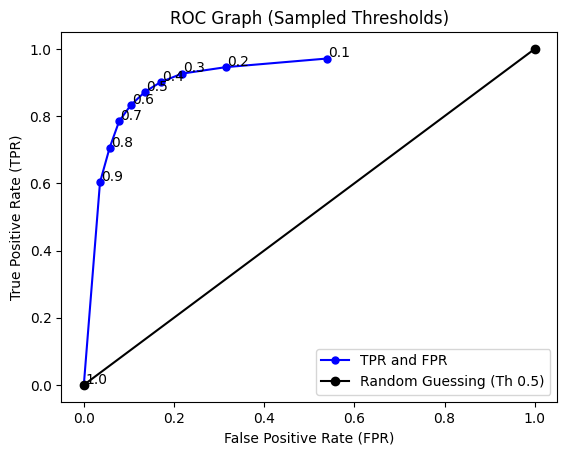

In [ ]:
def q2b_analysis(df):
    '''
    Calculates various performance metrics (Accuracy, F1-Score, etc.) across a range of 
    test probability thresholds. It identifies the optimal threshold based on the F1-Score 
    and plots the resulting (TPR, FPR) points.
    
    Returns:
        tuple: A DataFrame containing all metrics for each threshold (sorted by F1-Score), 
               and Series for TPR and FPR (also sorted by F1-Score).
    '''

    # Define the range of classification thresholds to test (from 0.1 to 1.0, stepping by 0.1).
    test_thresholds = np.arange(0.1, 1.01, 0.1)
    print('-'*100)
    print(f"Tested thresholds:\n{test_thresholds}")

    # Calculate confusion matrix components (TP, FP, TN, FN) and metrics for each threshold 'results' will be a list of lists or tuples.
    results = calculate_metrics_for_thresholds(df, test_thresholds)

    # Convert the results into a DataFrame and sort it descendingly by the 'f1_score' to easily identify the best threshold
    sorted_df = pd.DataFrame(
        results, columns=['tp', 'fp', 'tn',
                          'fn', 'threshold', 'accuracy', 'precision', 'recall', 'f1_score']).sort_values(by=['f1_score'], ascending=False)
    
    # Calculate True Positive Rate (TPR), which is also known as Recall or Sensitivity: TP / (TP + FN)
    sorted_df['tpr'] = sorted_df['tp'] / (sorted_df['tp']+sorted_df['fn'])

    # Calculate False Positive Rate (FPR): FP / (FP + TN)
    sorted_df['fpr'] = sorted_df['fp'] / (sorted_df['fp']+sorted_df['tn'])

    sorted_df = sorted_df.sort_values(by=['tpr', 'fpr'], ascending=[True,True])
    
    # Select the row with the highest F1-Score to identify the best threshold
    best_row = sorted_df.iloc[0]
    best_th = best_row['threshold']
    print('-'*100)
    print(f"Best threshold based on F1 Score is: {best_th}")

    # Print metrics for the best threshold
    print_metrics(
        tp=best_row['tp'],
        fp=best_row['fp'],
        tn=best_row['tn'],
        fn=best_row['fn'],
        th=best_row['threshold'],
        acc=best_row['accuracy'],
        pre=best_row['precision'],
        rec=best_row['recall'],
        f1=best_row['f1_score']
    )

    # Plot the calculated (FPR, TPR) pairs. These points form the sampled ROC curve
    plt.plot(sorted_df['fpr'], sorted_df['tpr'], label='TPR and FPR ', color='blue', marker='o', markersize=5)
    
    # Plot the diagonal line representing a random classifier (AUC = 0.5) for comparison
    plt.plot([0,1], [0,1], label='Random Guessing (Th 0.5)', color='black', marker='o')
    
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

    # Loop through each calculated point to annotate it with its corresponding threshold value.
    for i in range(len(sorted_df)):
        # Add a text annotation (label) to the plot for the current point.
        plt.annotate(
            # The text to display: The threshold value, formatted to one decimal place (e.g., '0.4').
            f"{sorted_df.iloc[i]['threshold']:.1f}",
            # The (x, y) coordinates where the annotation points to (the data point)
            (sorted_df['fpr'].iloc[i], sorted_df['tpr'].iloc[i]),
            # Specify that 'xytext' coordinates are offsets (in points/pixels) from the data point's coordinates
            textcoords="offset points",
            # The offset of the text label *from* the data point: 1 point to the right and 1 point up
            xytext=(1,1),
            ha='left',
            fontsize=10,
            color='black'
        )
    
    plt.legend(loc="best")
    plt.title('ROC Graph (Sampled Thresholds)')
    # Save the figure to a file.
    plt.savefig('results/q2b_roc_analysis.png', dpi=300)
    print("\nPlot saved as 'q2b_roc_analysis.png'.")

    # Return the F1-sorted DataFrame and the calculated TPR/FPR Series
    return sorted_df, sorted_df['tpr'], sorted_df['fpr']

# Execute the function and unpack the returned values
q2b_df, q2b_tpr, q2b_fpr = q2b_analysis(df)

----------------------------------------------------------------------------------------------------
Tested thresholds:
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
----------------------------------------------------------------------------------------------------
SEGMENT 0:

Best threshold based on F1 Score for segment '0' is: 1.0
----------------------------------------------------------------------------------------------------
Model Performance Metrics (Threshold 1.0)
True Positives (TP): 0.0
False Positives (FP): 0.0
True Negatives (TN): 413.0
False Negatives (FN): 669.0
Total samples: 1082.0

Accuracy: 0.3817
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
----------------------------------------------------------------------------------------------------
Confusion Matrix (Threshold 1.0)
                 Predicted
                 0       1
Actual 0     |   413.0   0.0   
Actual 1     |   669.0   0.0   
-----------------------------------------------------------------------------

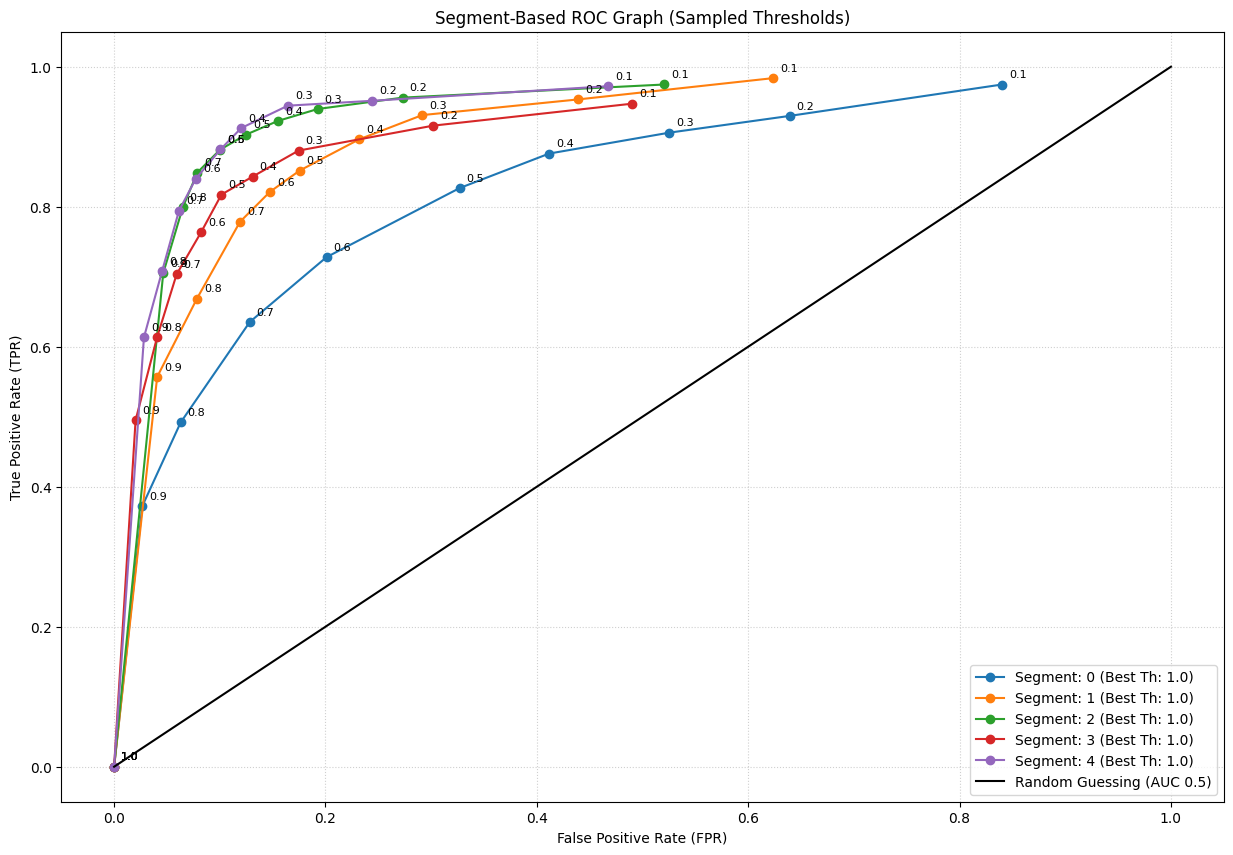

In [ ]:
def q2c_analysis_segmented(df):
    """
    Performs a segmented ROC curve analysis for model performance.

    It groups the input DataFrame by 'customer_segment', calculates True Positive Rate (TPR)
    and False Positive Rate (FPR) for various probability thresholds for each segment, 
    and plots the individual ROC curves on a single graph for comparison. 
    It identifies the optimal threshold (based on the highest F1-Score) for each segment.

    Args:
        df (pd.DataFrame): DataFrame containing model predictions and actual outcomes.
                           Must include 'customer_segment', 'actual_label', and 
                           the probability score used by 'calculate_metrics_for_thresholds'.

    Returns:
        dict: A dictionary where keys are customer segment names and values are 
              the corresponding optimal probability thresholds (float) based on F1-Score.
    """
        
    # Identify all unique customer segments present in the DataFrame
    segments = sorted(df['customer_segment'].unique(), key=int)
    
    # Initialize the plot figure and axes for the combined ROC graph
    plt.figure(figsize=(15, 10))
    
    # Define the range of classification thresholds to test (from 0.1 to 1.0, stepping by 0.1).
    test_thresholds = np.arange(0.1, 1.01, 0.1)
    print('-'*100)
    print(f"Tested thresholds:\n{test_thresholds}")

    # Dictionary to store the best calculated threshold for each segment
    best_thresholds = {}

    # Loop through each unique segment to calculate metrics and plot its ROC curve
    for segment in segments:
        # Filter the main DataFrame to get the data relevant to the current segment
        segment_df = df[df['customer_segment'] == segment].copy() 
        
        # Calculate performance metrics for the current segment across the defined thresholds
        results = calculate_metrics_for_thresholds(segment_df, test_thresholds) 

        # Convert results to a DataFrame and sort by 'f1_score' descendingly to find the optimal threshold for this segment
        sorted_df = pd.DataFrame(
            results, columns=['tp', 'fp', 'tn', 'fn', 'threshold', 
                              'accuracy', 'precision', 'recall', 'f1_score']
        ).sort_values(by=['f1_score'], ascending=False)

        # Calculate True Positive Rate (TPR), which is also known as Recall or Sensitivity: TP / (TP + FN)
        sorted_df['tpr'] = sorted_df['tp'] / (sorted_df['tp']+sorted_df['fn'])

        # Calculate False Positive Rate (FPR): FP / (FP + TN)
        sorted_df['fpr'] = sorted_df['fp'] / (sorted_df['fp']+sorted_df['tn'])

        sorted_df = sorted_df.sort_values(by=['tpr', 'fpr'], ascending=[True,True])
        
        # Select the row with the highest F1-Score to identify the best threshold
        best_row = sorted_df.iloc[0]
        best_th = round(best_row['threshold'], 1)
        best_thresholds[segment] = best_th

        print('-'*100)
        print(f"SEGMENT {segment}:\n")
        print(f"Best threshold based on F1 Score for segment '{segment}' is: {best_th:.1f}")

        # Print metrics for the best threshold
        print_metrics(
            tp=best_row['tp'],
            fp=best_row['fp'],
            tn=best_row['tn'],
            fn=best_row['fn'],
            th=round(best_row['threshold'], 1),
            acc=best_row['accuracy'],
            pre=best_row['precision'],
            rec=best_row['recall'],
            f1=best_row['f1_score']
        )

        # Plot the ROC curve for the current segment.
        plt.plot(sorted_df['fpr'], sorted_df['tpr'], 
                 label=f'Segment: {segment} (Best Th: {best_th:.1f})', 
                 marker='o') 
        
        # Annotate each sampled point with its corresponding threshold value.
        for i in range(len(sorted_df)):
            plt.annotate(
                # Threshold value formatted to one decimal place.
                f"{sorted_df.iloc[i]['threshold']:.1f}",
                # Coordinates (FPR, TPR) of the data point.
                (sorted_df['fpr'].iloc[i], sorted_df['tpr'].iloc[i]),
                # Specify text position relative to the point.
                textcoords="offset points",
                xytext=(5, 5), 
                ha='left',
                fontsize=8,
                color='black'
            )

    print('-'*100)
    # Add the diagonal line representing random guessing (baseline performance).
    plt.plot([0,1], [0,1], label='Random Guessing (AUC 0.5)', color='black')
    
    # Set axis labels and title.
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    
    # Display the legend in the bottom right corner.
    plt.legend(loc="lower right")
    plt.title('Segment-Based ROC Graph (Sampled Thresholds)')
    
    # Add a grid for better readability.
    plt.grid(True, linestyle=':', alpha=0.6)
    
    # Save the resulting figure to a file.
    plt.savefig('results/q2c_segmented_roc_analysis.png', dpi=300)
    print("\nPlot saved as 'q2c_segmented_roc_analysis.png'.")
    
    # Display the plot window (if running in a suitable environment).
    plt.show()

    # Return the dictionary containing the best thresholds for all segments
    return best_thresholds

q2c_best_thresholds = q2c_analysis_segmented(df)